In [46]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator import _merge_external_data
from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor


pd.set_option('display.max_columns', None)

In [2]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

X_merged 1 =  (8902, 21)
X_merged 2 =  (8902, 50)
X_merged 3 =  (8902, 79)
X_merged 4 =  (8902, 80)


/Users/Hugo/Desktop/X-HEC/Polytechnique/Semestre 1/Python_For_Data_Science/air_traffic_project/src/estimator.py:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


X_merged 5 =  (8902, 77)
X_merged 1 =  (2226, 21)
X_merged 2 =  (2226, 50)
X_merged 3 =  (2226, 79)
X_merged 4 =  (2226, 80)
X_merged 5 =  (2226, 77)


In [ ]:
X_train.shape

In [3]:
X_train_merged.shape

(8902, 77)

In [4]:
Xy_train_merged = X_train_merged.copy()
Xy_train_merged['Passengers'] = y_train
Xy_train_merged.to_csv('merged_xy.csv')

In [5]:
X_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8902 entries, 0 to 8901
Data columns (total 77 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Departure                       8902 non-null   object 
 1   Arrival                         8902 non-null   object 
 2   WeeksToDeparture                8902 non-null   float64
 3   std_wtd                         8902 non-null   float64
 4   Days_to_departure               8902 non-null   float64
 5   route_mean                      8902 non-null   float64
 6   year_departure                  8902 non-null   int64  
 7   day_departure                   8902 non-null   int64  
 8   n_days_departure                8902 non-null   int64  
 9   day_nb_mean                     8902 non-null   float64
 10  day_mean                        8902 non-null   float64
 11  week_mean                       8902 non-null   float64
 12  month_mean                      89

## Testing Without External Variables

In [6]:
# features = ['WeeksToDeparture', 'oil_stock_volume',
#                     'AAL_stock_price', 'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
#                     'latitude_deg_dep', 'longitude_deg_dep', 'pop2010_dep', 
#                     'latitude_deg_arr', 'longitude_deg_arr', 'pop2010_arr', 'distance',
#                     'LoadFactorDomestic_arr', 'PassengersDomestic_arr', 'closest_holidays_dep',
#                     'closest_holidays_arr', 'GDP_per_cap_dep', 'GDP_per_cap_arr', 'UnemploymentRate_dep', 'UnemploymentRate_arr', 
#                     'day_departure', 'weekday_departure', 'week_departure', 'n_days_departure', 'Max TemperatureC_dep', 
#             'Max TemperatureC_arr', 'Temp_diff', 'Temp_diff_abs']

# forest = RandomForestRegressor(min_samples_split=0.01, max_features=0.5, oob_score=True, verbose=0)
# score = cross_val_score(forest, X_forest, y_train, cv=5)

features_to_keep = ['WeeksToDeparture', 'week_mean', 'day_mean', 'month_mean', 'day_nb_mean', 
                   'route_mean', 'std_wtd', 'year_departure', 'n_days_departure']

X_train_data = X_train_merged[features_to_keep]

In [7]:
grid_params = {
    'n_estimators': [100],
    'min_samples_split': [0.001],
    'oob_score': [True]
#     'max_features': [0.5, 0.75]
}

gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=grid_params,
                  n_jobs=-1,
                  cv=5,
                  verbose=0)

gs.fit(X_train_data, y_train)        
print(gs.best_score_)
print(gs.best_params_) 

0.8409533577461079
{'min_samples_split': 0.001, 'n_estimators': 100, 'oob_score': True}


In [8]:
# Prediction performance on test set is not as good as on train set
X_test_data = X_test_merged[features_to_keep]

score_train = gs.score(X_train_data, y_train)
score_test = gs.score(X_test_data, y_test)

rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

print(f"Training RMSE: {rmse_train} and Score: {score_train}")
print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

Training RMSE: 0.223661205140686 and Score: 0.9493586595454636
Testing RMSE: 0.40543830189991825 and Score: 0.8405128613212569


## Testing With External Variables

In [9]:
features_to_keep = ['WeeksToDeparture', 'week_mean', 'day_mean', 'month_mean', 'day_nb_mean',
                    'route_mean', 'std_wtd', 'year_departure', 'n_days_departure',
                    'distance', 'closest_holidays_dep', 'closest_holidays_arr']

X_train_data = X_train_merged[features_to_keep]

grid_params = {
    'n_estimators': [100],
    'min_samples_split': [0.001],
    'oob_score': [False],
    'max_features': [0.75]
}

gs = GridSearchCV(estimator=RandomForestRegressor(),
                  param_grid=grid_params,
                  n_jobs=-1,
                  cv=5,
                  verbose=0)

gs.fit(X_train_data, y_train)        
print(gs.best_score_)
print(gs.best_params_)

# Prediction performance on test set is not as good as on train set
X_test_data = X_test_merged[features_to_keep]

score_train = gs.score(X_train_data, y_train)
score_test = gs.score(X_test_data, y_test)

rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

print(f"Training RMSE: {rmse_train} and Score: {score_train}")
print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

0.8551290543624812
{'max_features': 0.75, 'min_samples_split': 0.001, 'n_estimators': 100, 'oob_score': False}
Training RMSE: 0.21371650569619183 and Score: 0.9537618977541509
Testing RMSE: 0.38681521739089697 and Score: 0.8548278796737144


## XGBoost

In [34]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                alpha = 10, n_estimators = 100)
xg_reg.fit(X_train_data, y_train)

preds = xg_reg.predict(X_test_data)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.408865


In [38]:
data_dmatrix = xgb.DMatrix(data=X_train_data,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.499185,0.004296,9.499302,0.019121
1,8.559026,0.004322,8.559226,0.019004
2,7.713062,0.004306,7.713538,0.019255
3,6.953168,0.005264,6.953703,0.019538
4,6.268371,0.005504,6.268807,0.019735
5,5.652893,0.006174,5.653407,0.018964
6,5.100771,0.006627,5.101750,0.019375
7,4.604322,0.005798,4.605523,0.018813
8,4.156895,0.004773,4.158402,0.019122
9,3.755524,0.005428,3.756661,0.017600


In [39]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.515552
Name: test-rmse-mean, dtype: float64


## Linear Regression

In [10]:
# from sklearn.linear_model import LinearRegression

# features_to_keep = ['WeeksToDeparture', 'week_mean', 'day_mean', 'month_mean',
#                     'route_mean', 'std_wtd', 'year_departure', 'n_days_departure',
#                     'distance', 'closest_holidays_dep', 'closest_holidays_arr',
#                     'GDP_per_cap_dep', 'GDP_per_cap_arr',
#                     'SP_stock_volume', 'SP_stock_price',
#                     'oil_stock_price', 'oil_stock_volume',
#                     'AAL_stock_volume', 'AAL_stock_price',
#                     'Max TemperatureC_dep']

# X_train_data = X_train_merged[features_to_keep]

# grid_params = {}

# gs = GridSearchCV(estimator=LinearRegression(),
#                   param_grid=grid_params,
#                   n_jobs=-1,
#                   cv=5,
#                   verbose=0)

# gs.fit(X_train_data, y_train)        
# print(gs.best_score_)
# print(gs.best_params_)

# # Prediction performance on test set is not as good as on train set
# X_test_data = X_test_merged[features_to_keep]

# score_train = gs.score(X_train_data, y_train)
# score_test = gs.score(X_test_data, y_test)

# rmse_train = mean_squared_error(y_train, gs.predict(X_train_data), squared=False)
# rmse_test = mean_squared_error(y_test, gs.predict(X_test_data), squared=False)

# print(f"Training RMSE: {rmse_train} and Score: {score_train}")
# print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

### Feature Importance

In [11]:
# os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"
# dot_data = StringIO()
# export_graphviz(pipeline[0].estimators_[0], out_file=dot_data)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
# Image(graph.create_png())

# # viz = dtreeviz(forest_estimator.estimators_[0], X_train_data, y_train, feature_names=X_train_data.columns, target_name="Target")
# # viz

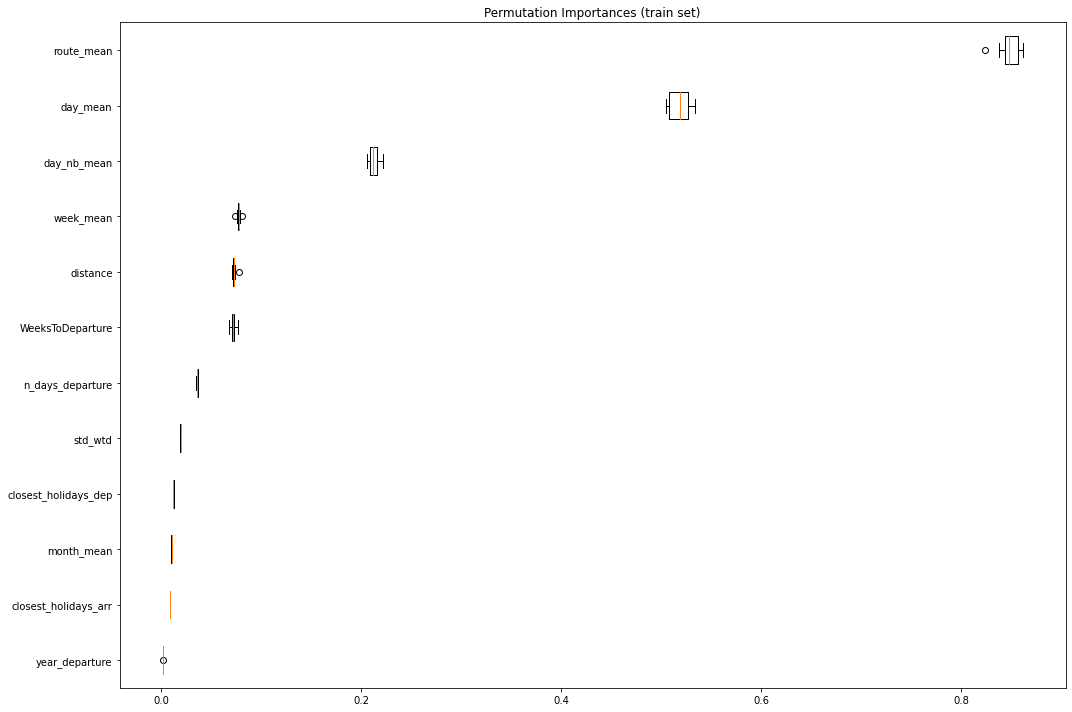

In [12]:
forest_estimator = gs.best_estimator_
pipeline = make_pipeline(forest_estimator)
pipeline.fit(X_train_data, y_train).score(X_test_data, y_test)

feature_importances = permutation_importance(
    pipeline, X_train_data, y_train, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_data.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

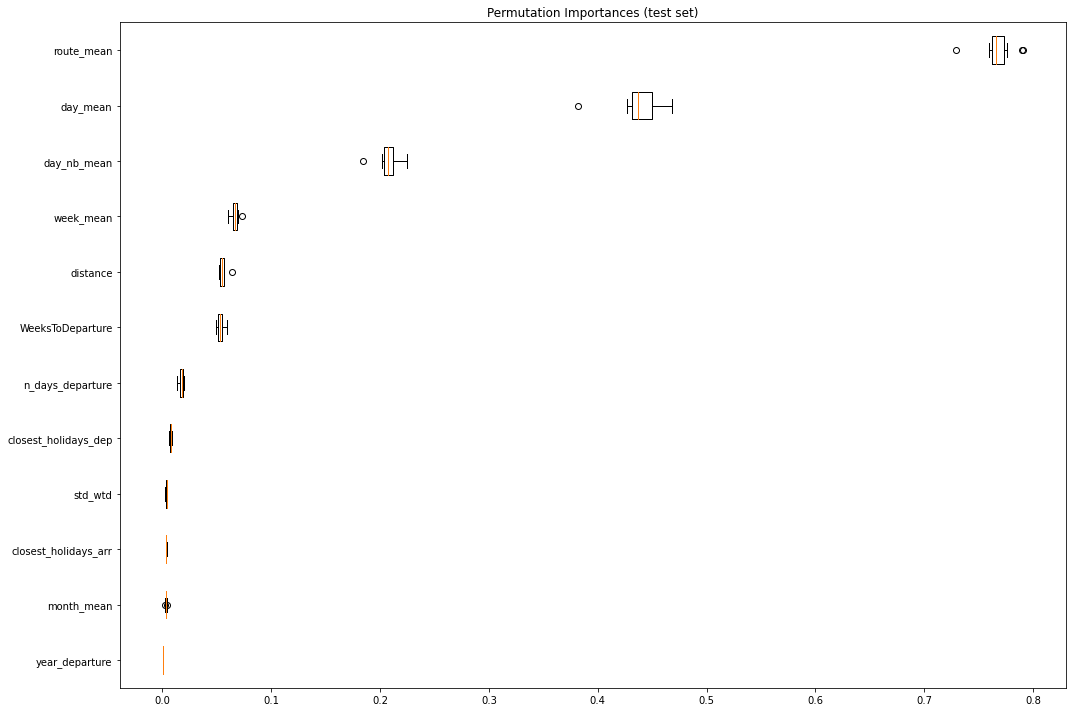

In [13]:
feature_importances = permutation_importance(
    pipeline, X_test_data, y_test, n_repeats=10
)

sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_test_data.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [58]:
#Keras Model
def build_nn():
    model= Sequential(
                [Dense(512,activation='selu',input_shape=[13]),
                 Dense(256,activation='selu'),
                 Dropout(0.2),
                 Dense(128,activation='selu'),
                 Dense(64,activation='selu'),
                 Dense(1)
    ])
    model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['RootMeanSquaredError'])
    return model

# wrap the model using the function you created
keras_reg = KerasRegressor(
                build_nn,epochs=1000,verbose=False)
keras_reg._estimator_type = "regressor"

# just create the pipeline
pipeline = Pipeline([
    ('clf',keras_reg)
])

pipeline.fit(X_train_data, y_train)

ValueError: in user code:

    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/envs/ramp-air-passengers/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 13 but received input with shape [None, 12]


In [55]:
y_train_pred = pipeline.predict(X_train_data)
y_test_pred = pipeline.predict(X_test_data)

In [56]:
score_train = pipeline.score(X_train_data, y_train)
score_test = pipeline.score(X_test_data, y_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Training RMSE: {rmse_train} and Score: {score_train}")
print(f"Testing RMSE: {rmse_test} and Score: {score_test}")

Training RMSE: 10.048321775982878 and Score: 11554.8701171875
Testing RMSE: 10.043891201279946 and Score: 11699.40234375


In [53]:
print(y_train_pred)

[1. 1. 1. ... 1. 1. 1.]


In [14]:
# plt.figure(figsize=(30, 30))
# sns.heatmap(abs(Xy_train.corr()), cmap='BrBG', annot=True, vmin=-1, vmax=1)

In [15]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
# #     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
    
#     return accuracy

In [16]:
# plt.figure(figsize=(8, 15))
# heatmap = sns.heatmap(Xy_train.corr()[['Passengers']].sort_values(by='Passengers', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':18}, pad=16);

In [17]:
# from sklearn.neighbors import KNeighborsRegressor

# grid_params = {
#     'n_neighbors': range(1, 200),
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'],
# }

# gs = GridSearchCV(
#     KNeighborsRegressor(),
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [18]:
# print(gs_results.best_score_)
# print(gs_results.best_estimator_)
# print(gs_results.best_params_)

In [19]:
# X_train, y_train = problem.get_train_data('..')

In [20]:

# grid_params = {
#     'randomforestregressor__n_estimators': [50, 100],
#     'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
#     'randomforestregressor__max_depth': [4, 6, 8],
#     'randomforestregressor__criterion': ['mse']
# }

# # pipe = make_pipeline(StandardScaler(with_mean=False), RandomForestRegressor())

# gs = GridSearchCV(
#     pipe,
#     grid_params,
#     verbose=1,
#     cv=3,
#     n_jobs=-1
# )

# gs_results = gs.fit(X_train, y_train)

In [21]:
# print(gs_results.best_score_)
# print(gs_results.best_estimator_)
# print(gs_results.best_params_)

## Feature Importance

In [22]:
# from sklearn.inspection import permutation_importance

# feature_importances = permutation_importance(
#     pipe, X_train, y_train, n_repeats=10
# )
# sorted_idx = feature_importances.importances_mean.argsort()

In [23]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.boxplot(feature_importances.importances[sorted_idx].T,
#            vert=False, labels=X_train.columns[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

In [24]:
# feature_importances = permutation_importance(
#     pipe, X_test, y_test, n_repeats=10
# )
# sorted_idx = feature_importances.importances_mean.argsort()

In [25]:
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.boxplot(feature_importances.importances[sorted_idx].T,
#            vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()

## Predictor Selection

In [26]:
# X_train = sm.add_constant(X_train)
# print(X_train.info())
# print("X as array:", np.asarray(X_train))
# print("y as array:", np.asarray(y_train))
# model_both = forwardSelection(X_train.astype(float), y_train.astype(float))

In [27]:
# def plot_pca(data, index, n_components=2):
#     """ Plot the PCA transformation of Sklearn module

#     Args:
#         data (np.array): Original scaled data as numpy array 
#                          (n samples, d features)
#         index (list): list of strings to label samples
#         n_components (int, optional): Number of Principal Components to keep. 
#                                       Defaults to 2.
#     """

#     pca = PCA(n_components=n_components)
#     pca_data = pca.fit_transform(data)
#     per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

#     labels = []
#     for i in range(len(per_var)):
#         labels.append('PC' + str(i + 1) + " : " + str(per_var[i]))

#     pca_df = pd.DataFrame(pca_data, index=index, columns=labels)

#     if n_components == 2:
#         plt.scatter(pca_df[labels[0]], pca_df[labels[1]], alpha=0.1)
#         plt.xlabel(labels[0])
#         plt.ylabel(labels[1])
# #         for sample in pca_df.index:
# #             plt.annotate(sample, (pca_df.loc[sample, labels[0]], pca_df.loc[sample, labels[1]]), rotation=45)
    
#     elif n_components == 3:
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         X = pca_df[labels[0]]
#         Y = pca_df[labels[1]]
#         Z = pca_df[labels[2]]
#         ax.scatter(X, Y, Z)
#         ax.set_xlabel(labels[0], labelpad=20)
#         ax.set_ylabel(labels[1], labelpad=20)
#         ax.set_zlabel(labels[2], labelpad=20)
#         for sample in pca_df.index:
#             ax.text(pca_df.loc[sample, labels[0]], pca_df.loc[sample, labels[1]], pca_df.loc[sample, labels[2]],
#                     '%s' % sample, size=20, color='k', rotation=50) 
#     plt.title("Data projected on space given by the {} principal components.".format(n_components))
#     plt.show()
    
#     plt.hist(per_var)
#     plt.show()
        

# scaler = StandardScaler()
# scaler.fit(X_train)

# scaled_X_train_np = scaler.transform(X_train)
# scaled_X_train_df = pd.DataFrame(scaled_X_train_np, index=X_train.index, columns=X_train.columns)
# # scaled_consumption_df 

# pca = PCA(n_components=25)
# pca_data = pca.fit_transform(scaled_X_train_np)
# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# print(per_var)
# print(sum(per_var))

## Model

In [28]:
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.linear_model import LinearRegression

# pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'),
#                     StandardScaler(with_mean=False),
#                     LinearRegression())

In [29]:
# pipe.fit(X_train, y_train)
# y_train_pred = pipe.predict(X_train)
# #print("10 first y_train pred = ", y_train_pred[:10])
# #print("10 first y_train = ", y_train[:10])
# print("Score on train set = ", pipe.score(X_train, y_train))

# mean_error_train = mean_squared_error(y_train, y_train_pred)
# print("Mean square error = ", mean_error_train)

# y_test_pred = pipe.predict(X_test)
# #print("10 first y_test pred = ", y_test_pred[:10])
# #print("10 first y_test = ", y_test[:10])
# print("Score on test set = ", pipe.score(X_test, y_test))

# mean_error_test = mean_squared_error(y_test, y_test_pred)
# print("Mean square error = ", mean_error_test)